### Dataset Preparation (To download on colab through opendatasets)

In [38]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od
dataset_url = "https://www.kaggle.com/datasets/grassknoted/asl-alphabet"
od.download(dataset_url)

Verify the downloads folder

In [ ]:
!ls ./asl-alphabet/

### Necessary imports

In [7]:
import os
import torch
import torchvision
import string
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import PIL.Image as Image
# from torchsummary import summary
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import TensorDataset
from torchvision.utils import make_grid
import torchvision.models as models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
from torchinfo import summary

import random
import time
%matplotlib inline
from copy import copy

#### Data loading, visualization, split

In [42]:
data_dir = './asl-alphabet' #'/content/drive/MyDrive/EE-541/asl_project/asl-alphabet' 
classes = os.listdir(data_dir+'/asl_alphabet_train/asl_alphabet_train')
num_classes = len(classes)
print(num_classes)

29


#### Data Preprocessing

In [43]:
#resized to 224x224 because finetuning ResNet which is trained for 224x224 resolution
train_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(224), 
    transforms.ToTensor()
])

#### Using `torchvision.datasets.ImageFolder` as the data is organized in a way for which ImageFolder is best suited

In [46]:
dataset = ImageFolder(data_dir+'/asl_alphabet_train/asl_alphabet_train',transform=train_transforms) #note it will be splitted into train and val

In [47]:
random_seed = 42 #For reproducibility
torch.manual_seed(random_seed);

#### Train Val split (80/20)

In [48]:
val_size = int(0.20 * len(dataset))
train_size = len(dataset) - val_size

train_data, val_data = random_split(dataset, [train_size, val_size])

In [49]:
# use train transform for train
train_data.dataset = copy(dataset)
train_data.dataset.transform = train_transforms

# use test transform for validation
# val_data.dataset = copy(val_data)
val_data.dataset.transform = test_transforms

In [50]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(val_data)}')
# print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 69600
Number of validation examples: 17400


Data Loader

In [51]:
batch_size = 50
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_data, batch_size*2, num_workers=1, pin_memory=True)

### Visualizing samples

torch.Size([3, 224, 224])
Label: C


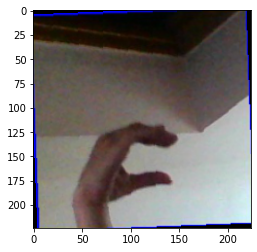

In [52]:
img, label = train_data[0]
print(img.shape)
print('Label:', dataset.classes[label])
plt.imshow(img.permute(1,2,0))

torch.Size([3, 224, 224])
Label: W


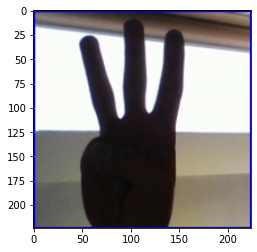

In [53]:
img, label = val_data[0]
print(img.shape)
print('Label:', dataset.classes[label])
plt.imshow(img.permute(1,2,0))

In [54]:
def show_batch(dl):
  for images, labels in dl:
    print(len(images))
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images[:49], nrow=7).permute(1, 2, 0))
    break

50


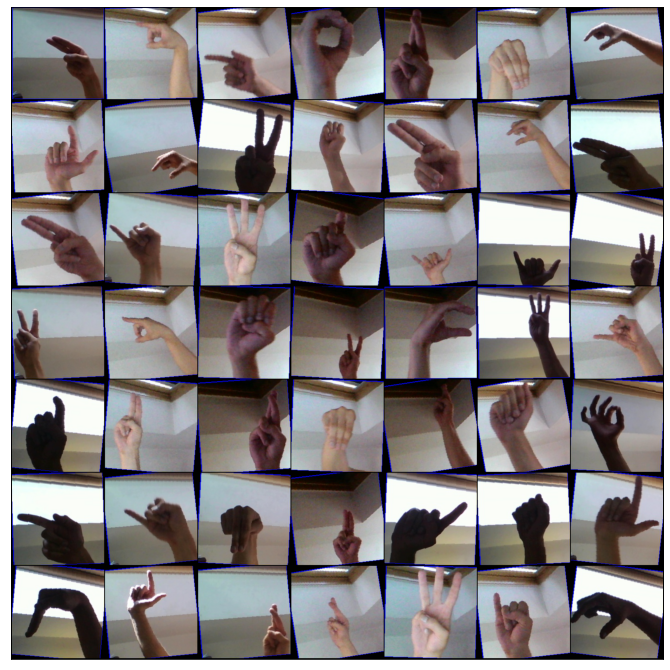

In [55]:
show_batch(train_dl)

### Model and Hyperparameters setting

In [56]:
#device selection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Modify below to resnet18 or resnet34 for trying ResNet variants

In [35]:
#modify below to resnet18 or resnet50 for trying ResNet variants
model = torchvision.models.resnet34(pretrained=True)
# model

In [36]:
#we are finetuning hence freeze params
for param in model.parameters():
    param.requires_grad = False

in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, 29)
# model

#### In case want to try CNNBaseline comment above 2 cells and try below cell

#### **Note:** Run below cell only when trying CNNBaseline

In [ ]:
class CNNBaseline(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.conv4 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 12 * 12, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 29)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CNNBaseline()

In [ ]:
# summary(model, (1,3,224,224)) #uncomment this for model summary

In [ ]:
model.to(device)

#### Tune the hyperparameters

In [60]:
val_size = val_size 
batch_size = 50
num_epoch = 10
learning_rate = 0.001 #tried 0.01 and 0.0001 former was toggling and later slow in convergence
num_classes = 29

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Can try different lr_schedulers
# scheduler = StepLR(optimizer, step_size=10, gamma=0.1) #don't forget to use scheduler.step while training

#### Have tried Tensorboard for visualization locally, disabled due to some issues on colab

In [62]:
import datetime
from torch.utils.tensorboard import SummaryWriter
from tensorflow import summary
# %reload_ext tensorboard
import os
logs_base_dir = "/content/drive/MyDrive/EE-541/asl_project/logs"
os.makedirs(logs_base_dir, exist_ok=True)

# %tensorboard --logdir=logs_base_dir

In [63]:
writer = SummaryWriter()
images, labels = next(iter(train_dl))
writer.add_images("Image", images)
writer.add_graph(model, images.to(device))

### Train and Validate

#### Modify the `base_dir` variable below where the models will be saved. 

Currently two `.pth` file is created one with `_full` which has state_dict for optimizer, scheduler (if set), and other statistics that can be reutilized in case the training stops in between due to GPU constraints or connectivity issues 

In [ ]:
from tqdm import tqdm
from time import time

print_every = 1000
steps = 0
num_epoch = 15 #modify based on if training from scratch/pretraining

base_dir = '/content/drive/MyDrive/EE-541/asl_project/models/resnet50/'

#to generate the plots
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

model.to(device)

for epoch in tqdm(range(num_epoch)):
    iterations = 0
    running_loss = 0
    correct_train = 0
    total_train = 0
    start_time = time()
    
    model.train()
    for i, (images, labels) in enumerate(train_dl):
        steps += 1
        images = images.to(device)
        labels = labels.to(device)
            
        # Forward pass
        output = model(images)
        loss = criterion(output, labels)
    
        correct_train += (torch.max(output, dim=1)[1] == labels).sum()
        total_train += labels.size(0)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        iterations += 1
        running_loss += loss.item()
        writer.add_scalar("Loss/train", loss, epoch)
        if steps % print_every == 0:
            print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dl)}]. Train loss {running_loss / steps}.', end=' ')
            train_acc = correct_train / total_train * 100
            train_accuracies.append(train_acc)
            print(f'Train acc {train_acc}.', end=' ')
            writer.add_scalar("Acc/train", train_acc)
            train_accuracies.append(train_acc)
            with torch.no_grad():
                model.eval()
                correct_val, total_val = 0, 0
                val_loss = 0
                for images, labels in val_dl:
                    images = images.to(device)
                    labels = labels.to(device)
                    output = model(images)
                    loss = criterion(output, labels)
                    val_loss += loss.item()

                    correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                    total_val += labels.size(0)
            val_acc = correct_val / total_val * 100
            val_accuracies.append(val_acc)
            print(f'Val loss {val_loss / len(val_dl)}. Val acc {val_acc}')
            
            writer.add_scalar("Loss/val", val_loss, epoch)
            writer.add_scalar("Acc/val", val_acc, epoch)
            train_losses.append(running_loss / total_train)
            val_losses.append(val_loss / total_val)
        
        # scheduler.step()
    print(f'Epoch took {time() - start_time}') 
    torch.save(model, f'{base_dir}+res34_sc_checkpoint_{correct_val / total_val * 100:.2f}.pth')
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_losses,
            'val_accuracy': val_accuracies,
            'train_loss': train_losses,
            'train_accuracy':train_accuracies,
            # 'scheduler': scheduler.state_dict()
            }, f'{base_dir}+res34_sc_full_{correct_val / total_val * 100:.2f}.pth')


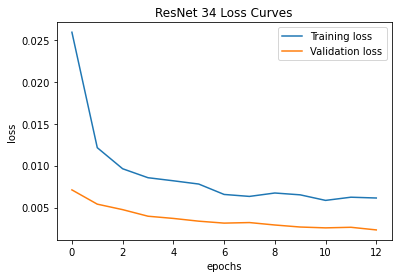

In [202]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("ResNet 34 Loss Curves")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig("/content/drive/MyDrive/EE-541/asl_project/logs/resnet34_loss_curve.png")
plt.show()

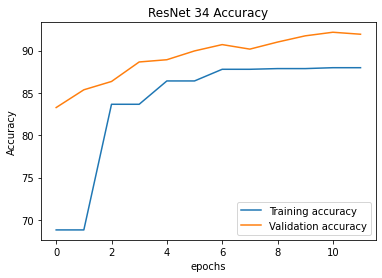

In [203]:
tr_acc = [acc.to('cpu') for acc in train_accuracies]
vl_acc = [acc.to('cpu') for acc in val_accuracies]
plt.plot(tr_acc[:12], label='Training accuracy')
plt.plot(vl_acc[:12], label='Validation accuracy')
plt.legend()
plt.title("ResNet 34 Accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.savefig("/content/drive/MyDrive/EE-541/asl_project/logs/resnet34_accuracy_curve.png")
plt.show()


#### Test on unseen dataset (test set)

In [64]:
from pathlib import Path
from PIL import Image


test_data_path = Path('./asl-alphabet/asl_alphabet_test/asl_alphabet_test')

#code utilized from https://www.kaggle.com/code/julichitai/asl-alphabet-classification-using-pytorch
class ASLTestDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, transforms=None):
        super().__init__()
        
        self.transforms = transforms
        self.imgs = sorted(list(Path(root_path).glob('*.jpg')))
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert('RGB')
        
        label = img_path.parts[-1].split('_')[0]
        if self.transforms:
            img = self.transforms(img)
        
        return img, label

28


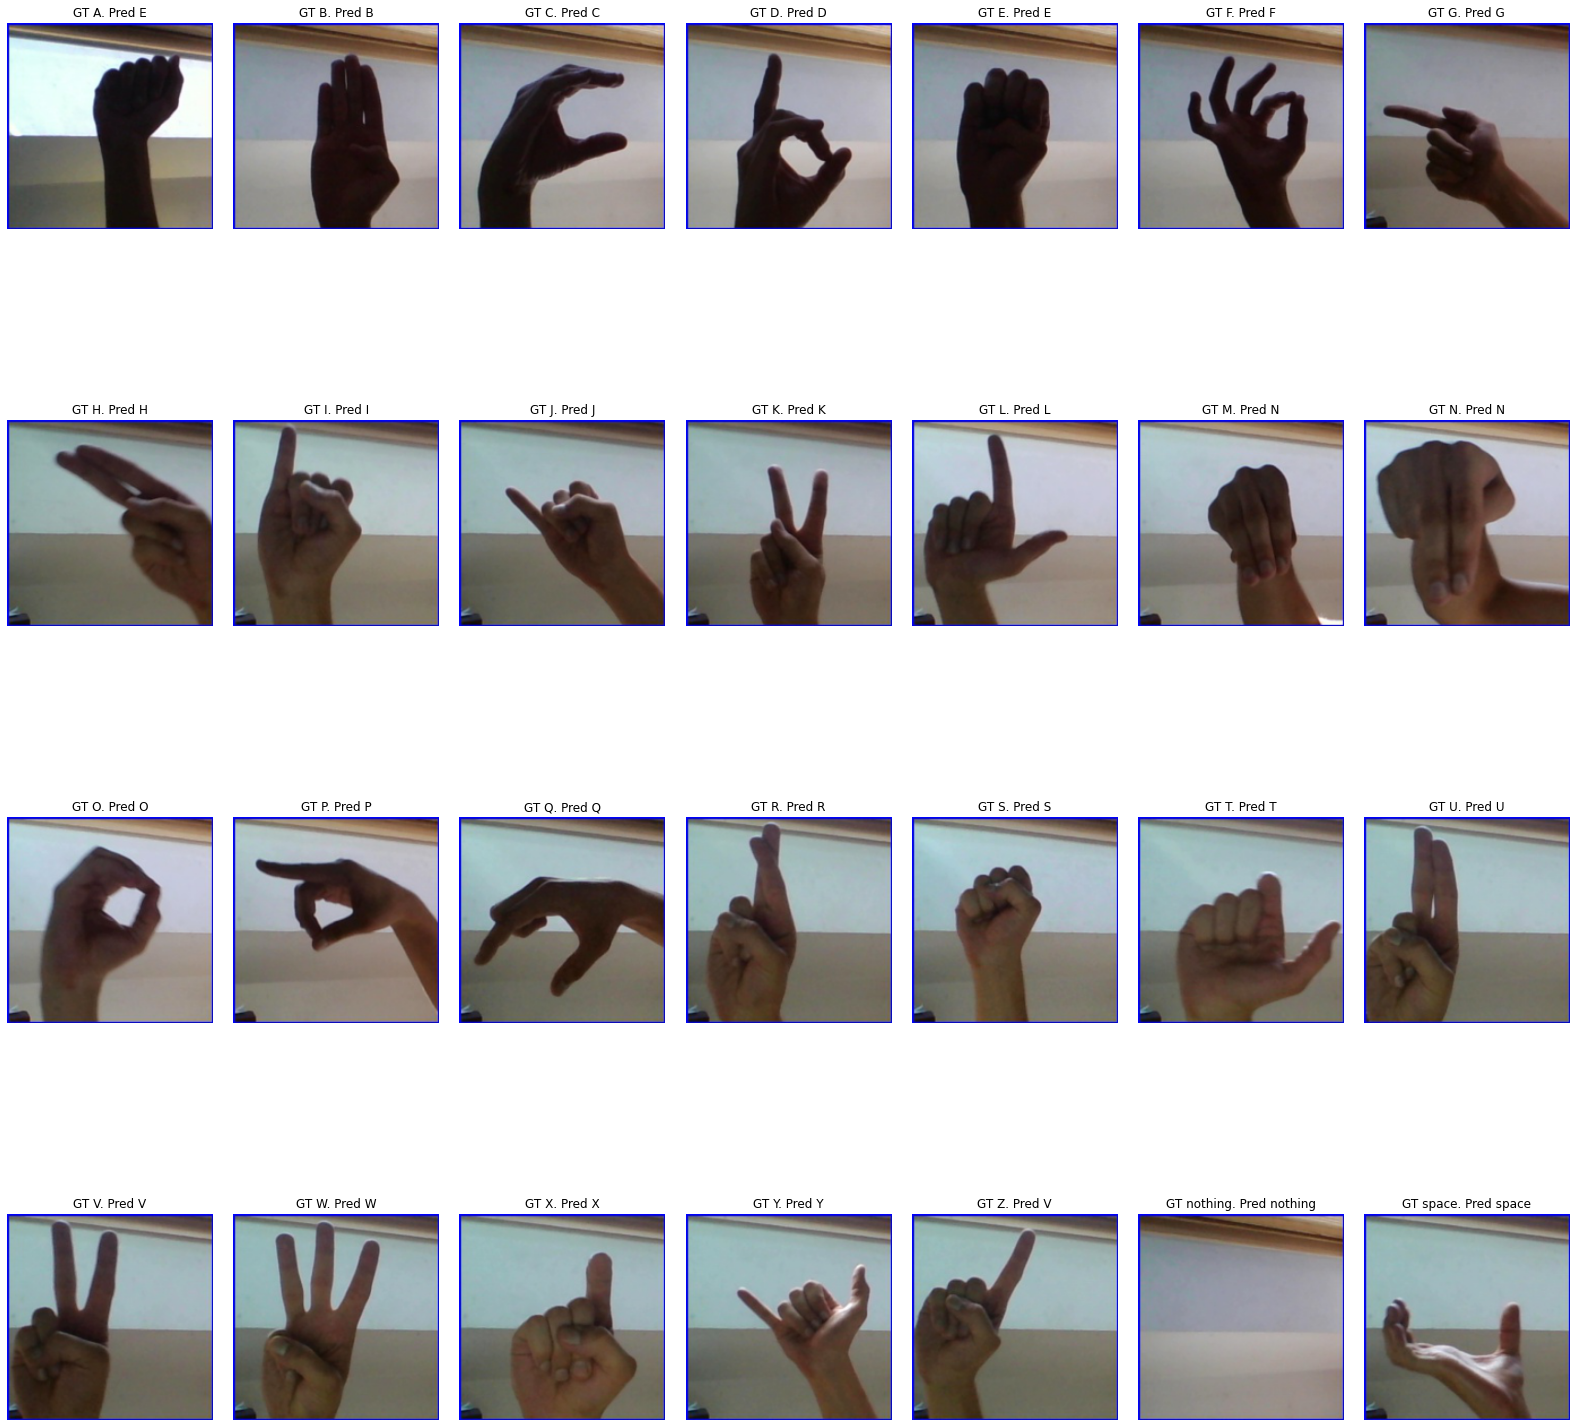

In [208]:
test_dataset = ASLTestDataset(test_data_path, transforms=test_transforms)
print(len(test_dataset))
columns = 7
row = round(len(test_dataset) / columns)

fig, ax = plt.subplots(row, columns, figsize=(columns * row, row * columns))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

i, j = 0, 0
indx = 0
ypred = []
yact = []
for img, label in test_dataset:
    img = torch.Tensor(img)
    img = img.to(device)
    model.eval()
    prediction = model(img[None])
    yact.append(label)
    ypred.append(classes[torch.max(prediction, dim=1)[1]])
    ax[i][j].imshow(img.cpu().permute(1, 2, 0))
    ax[i][j].set_title(f'GT {label}. Pred {classes[torch.max(prediction, dim=1)[1]]}')
    ax[i][j].axis('off')
    j += 1
    if j == columns:
        j = 0
        i += 1

plt.savefig("/content/drive/MyDrive/EE-541/asl_project/logs/test_result_resnet34.png") 
plt.show()

In [209]:
from sklearn.metrics import classification_report
print(classification_report(yact, ypred))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00         1
           B       1.00      1.00      1.00         1
           C       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         1
           E       0.50      1.00      0.67         1
           F       1.00      1.00      1.00         1
           G       1.00      1.00      1.00         1
           H       1.00      1.00      1.00         1
           I       1.00      1.00      1.00         1
           J       1.00      1.00      1.00         1
           K       1.00      1.00      1.00         1
           L       1.00      1.00      1.00         1
           M       0.00      0.00      0.00         1
           N       0.50      1.00      0.67         1
           O       1.00      1.00      1.00         1
           P       1.00      1.00      1.00         1
           Q       1.00      1.00      1.00         1
           R       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


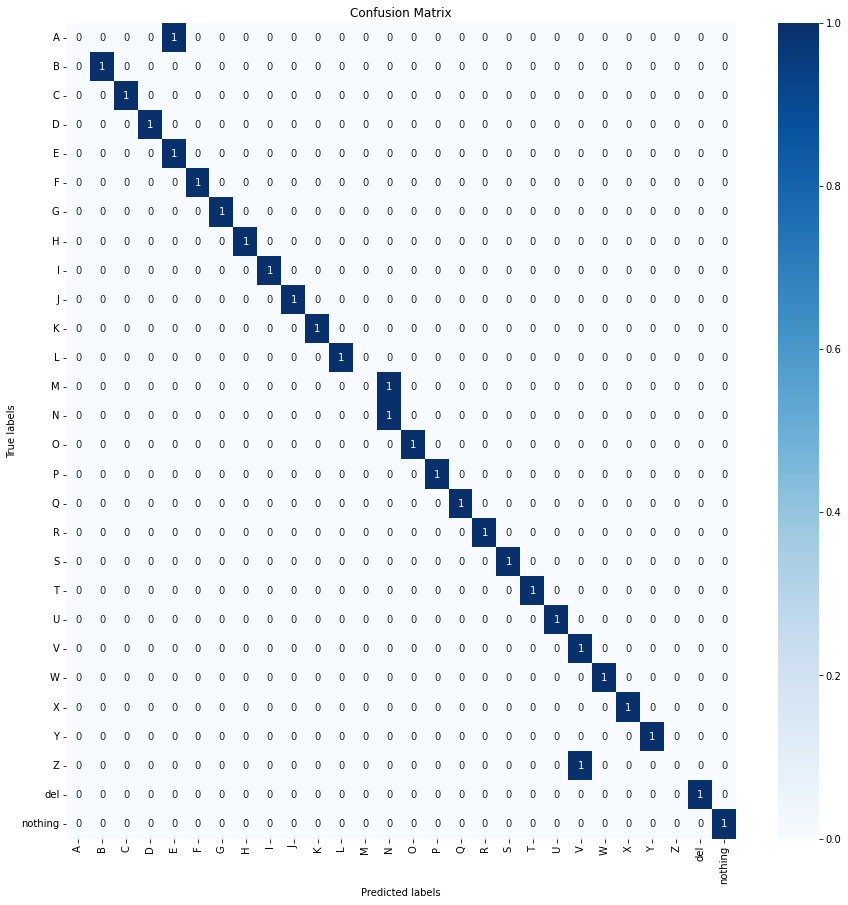

In [210]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(yact, ypred)
classes = train_dl.dataset.dataset.classes
plt.figure(figsize=(15,15))
ax= plt.subplot()
sns.heatmap(cm, annot=True,fmt='d', cmap='Blues',ax=ax)
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(classes, rotation=90); ax.yaxis.set_ticklabels(classes, rotation=0);
plt.savefig("/content/drive/MyDrive/EE-541/asl_project/logs/resnet34_heatmap_test.png")

### Acknowledgement
This project builds upon the solution prepared by the fellow kagglers from whose notebook we adapted our code. Few of the kagglers whose notebooks that was helpful in this project are given below:
1. https://www.kaggle.com/grassknoted (Dataset contributor)
2. https://www.kaggle.com/julichitai
3. https://jovian.ai/gry-galario/project
